In [ ]:
## Julia program to read a selected .HXV file and display 30-minute time series plots
## JW December 2022
#using ContinuousWavelets 
using CSV
using Dates, DataFrames, Distributions #, DSP
using Gtk
using LaTeXStrings
using NativeFileDialog
using Plots
using Printf
using Statistics #, StatsPlots
using Tk


function get_displacements(arry)
#####################################
    displacements = []

    if length(arry[1]) == 3
    
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^2 + parse(Int, SubString.(i, 2, 2), base=16)*16^1 + parse(Int, SubString.(i, 3, 3), base=16)*16^0)
        end
        
    else
        
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^1 + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
        end
        
    end

    displacements[findall(>=(2048), displacements)] = 2048 .- displacements[findall(>=(2048), displacements)];
    
    return(displacements./100)
    
    end     # get_displacements()


function get_HNW(infil)
#####################################
        
    global df = DataFrame(CSV.File(infil,header=0, delim=",", types=String));

    # Calculate sequence numbers
    arry = SubString.(df.Column1, 3, 4)

    global sequence = []

    for i in arry
        append!(sequence,parse(Int, SubString.(i, 1, 1), base=16)*16^1 + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
    end

    # Calculate heave WSEs
    arry = SubString.(df.Column3, 1, 3);
    heave = get_displacements(arry);

    # Calculate north WSEs
    arry = SubString.(df.Column3, 4, ) .* SubString.(df.Column4, 1, 2)
    north = get_displacements(arry);

    # Calculate north WSEs
    arry = SubString.(df.Column4, 3, 4) .* SubString.(df.Column5, 1, 1)
    west = get_displacements(arry);

    return(heave, north, west)

    end    # get_HNW()


function calc_wse(infil, wse_df, start_date)
#####################################    
    
    heave, north, west = get_HNW(infil)
    
    # Identify any gaps in the recorded data
    tt = [0]
    append!(tt,diff(sequence))
    tt[tt.<0] .+= 256;
    tt1 = cumsum(tt);
    
    if length(tt1) > 2304
        tt1 = tt1[1:2304]
    end

    [wse_df[tt1[i]+1,2] = heave[i] for i in 1:length(tt1)];
    [wse_df[tt1[i]+1,3] = north[i] for i in 1:length(tt1)];
    [wse_df[tt1[i]+1,4] = west[i] for i in 1:length(tt1)];
    
    return(wse_df)
    
    end    # calc_wse()


function spike_value(wse)
#####################################    
    median_value = median(wse)
    std_value = std(wse)

    return(median_value + 3*std_value)

    end    # spike_value()


function plot_wses(wse_df)
#####################################
    
    spike = spike_value(wse_df.Heave)
    heave_spikes = findall(i->(i>=spike), abs.(wse_df.Heave));

    spike = spike_value(wse_df.North)
    north_spikes = findall(i->(i>=spike), abs.(wse_df.North));

    spike = spike_value(wse_df.West)
    west_spikes = findall(i->(i>=spike), abs.(wse_df.West));
    
    # create plots of heave, north, and west
    title_string = Dates.format(first(wse_df.Date), "dd/mm/yyyy HH:MM") * " UTC"
    p1_hnw = scatter(wse_df[heave_spikes,:].Date, wse_df[heave_spikes,:].Heave, label="", ylabel="Heave", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
    p1_hnw = plot!(wse_df.Date,wse_df.Heave, label="", c="#4a536b", lw=0.5, title=title_string, titlefontsize=12) ##last(split(infil,"\\")))

    # get plotting limits
    x_lim1 = xlims(p1_hnw)[1]; y_lim1 = ylims(p1_hnw)[1]
    x_lim2 = xlims(p1_hnw)[2]; y_lim2 = ylims(p1_hnw)[2]

    p2_hnw = scatter(wse_df[north_spikes,:].Date, wse_df[north_spikes,:].North, label="", ylabel="North", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
    p2_hnw = plot!(wse_df.Date,wse_df.North, label="", c="#aed6dc", lw=0.5)
    p3_hnw = scatter(wse_df[west_spikes,:].Date,wse_df[west_spikes,:].West, label="", ylabel="West", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
    p3_hnw = plot!(wse_df.Date,wse_df.West, label="", c="#ff9a8d", lw=0.5)

    hline!(p1_hnw, [0], lw=0.5, label="")
    hline!(p2_hnw, [0], lw=0.5, label="")
    hline!(p3_hnw, [0], lw=0.5, label="")

    # get plotting limits
    x_lim1 = xlims(p1_hnw)[1]; y_lim1 = ylims(p1_hnw)[1]
    x_lim2 = xlims(p1_hnw)[2]; y_lim2 = ylims(p1_hnw)[2]

    # display plots to screen
    tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
    ticks = Dates.format.(tm_tick,"MM:SS")


    # display plots to screen
    plot_wse = Plots.plot(p1_hnw, p2_hnw, p3_hnw, layout = (3, 1), size = (1400, 600),
        xlim=(first(wse_df.Date),last(wse_df.Date)), xticks=(tm_tick,ticks), xtickfontsize=7,ytickfontsize=8,
        framestyle = :box,fg_legend=:transparent, legend=:bottomleft,
        leftmargin = 15Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)            

    display(plot_wse)
    
    return()
    
    end    # plot_wses)


function do_fft(heave, N)
################################################
# calculate the Fourier coefficients vide (5.6.2)
    return([sum([heave[k]*exp(2*pi*-1im*k*l/N) for k in (1:N)]) for l in (1:N)])
end    # do_fft()


function calc_psd(Hl, N)
################################################
# The power spectral density is obtained from the Fourier coefficients    
    PSD = zeros(trunc(Int,N/2))

    for l = 1:trunc(Int,N/2)   
        if (l==1) || (l==trunc(Int,N/2)-1)
            PSD[l] = abs(Hl[l])^2
        else
            PSD[l] = abs(Hl[l])^2+abs(Hl[N-l-1])^2
        end
    end

    # Smooth coefficients vide (5.6.6)
    PSD_smooth = PSD
    [PSD_smooth[i] = PSD[i-1]/4 + PSD[i]/2 + PSD[i+1]/4 for i in (2:trunc(Int,N/2)-1)]

    return(PSD_smooth)
end    # calc_psd()


function calc_tp5(f2,Sf)
##########################################
# Calculate Tp5 via Read method
    Sf_max = maximum(Sf)

    numerator = 0; denominator = 0

    Sf_sum = cumsum(Sf.*Sf_max).^5

    for i in 1:length(f2)
        w = Sf[i] / Sf_max
        numerator +=  f2[i] * w^5
        denominator += w^5
    end

    Fp5 = numerator / denominator
    
    return(Fp5)    # calc_tp5()

    end    # calc_tp5()


function calc_hm0(Sf,freq)
##########################################    
    ax1 = (last(freq) - first(freq)) / (length(freq)-1)

    # calc spectral moments m0, m1, m2, m3, and m4
    s00 = 0; m0 = 0

    for ii in 1:128

        s00 += freq[ii]^0 * Sf[ii];

    end

    m0 = 0.5*ax1*(first(freq)^0*first(Sf) + 2*s00 + last(freq)^0*last(Sf))

    return(4 * m0^0.5)

    end    # calc_hm0()


function calculate_frequency_domain_parameters(f2, spectra)
##########################################
# Calculate frequency-domain parameters    
# Calls: calc_tp5()
    ax1 = (last(f2) - first(f2)) / (length(f2)-1)

    # calc spectral moments m0, m1, m2, m3, and m4
    s00 = 0; s01 = 0; s02 = 0; s03 = 0; s04 = 0;
    m0 = 0; m1 = 0; m2 = 0; m3 = 0; m4 = 0

    for ii in 1:128

        s00 += f2[ii]^0 * spectra[ii]
        s01 += f2[ii]^1 * spectra[ii]
        s02 += f2[ii]^2 * spectra[ii]
        s03 += f2[ii]^3 * spectra[ii]
        s04 += f2[ii]^4 * spectra[ii]

    end

    m0 = 0.5*ax1*(first(f2)^0*first(spectra) + 2*s00 + last(f2)^0*last(spectra))
    m1 = 0.5*ax1*(first(f2)^1*first(spectra) + 2*s01 + last(f2)^1*last(spectra))
    m2 = 0.5*ax1*(first(f2)^2*first(spectra) + 2*s02 + last(f2)^2*last(spectra))
    m3 = 0.5*ax1*(first(f2)^3*first(spectra) + 2*s03 + last(f2)^3*last(spectra))
    m4 = 0.5*ax1*(first(f2)^4*first(spectra) + 2*s04 + last(f2)^4*last(spectra))

    ##println("m0 = ",m0," m1 = ",m1, " m2 = ",m2, " m3 = ",m2, " m4 = ",m4)

    # calc wave parameters Hm0, Hrms, T01, T02, Tc
    Hm0 = 4*sqrt(m0)     # Tucker & Pitt p.32 (2.2-6b)
    Hrms = sqrt(8*m0)    # Goda 2nd. Edition p.262 (9.15)
    T01 = m0/m1          # Tucker & Pitt p.41 Table 2.2 
    T02 = sqrt(m0/m2)    # Tucker & Pitt p.40 (2.3-2)
    Tc = sqrt(m2/m4)     # Tucker & Pitt p.41 Table 2.2 - also see Notes

    # identify spectral peak and frequency as peak
    Fp = f2[argmax(spectra)]
    Tp = 1/Fp
    fp5 = calc_tp5(f2, spectra)
    Tp5 = 1/fp5

    # calculate spectral width vide Tucker and Pitt p.85 (5.2-8)
    # Note: for JONSWAP, v = 0.39; for PM, v = 0.425
    v = (m0*m2 / m1^2 - 1)^0.5

    # calculate Skewness vide Tucker and Pitt p.109 (5.5-17)
    Skewness = (m0^2 * m3/m1^3 - 3*v^2 - 1) / v^3;
    
    return(Hm0, Hrms, T01, T02, Tc, Tp, fp5, Tp5, Skewness)
    
    end    # calculate_frequency_domain_parameters()


function calc_representative_spectra(frequency,Hm0,Tp,gamma)
##########################################    
    """
    function to calculate representative spectrum based on the Jonswap formula in Tucker and Pitt p.339 (10.3-9a)

    inputs:
        frequency - array of spectral frequencies
        Hm0 - floating point value
        Tp - floating point value
        gamma - floating point value - Peak ehhancement factor (Enter 1 for PM, or 3.3 for Jonswap)

        Typical calls:
        Spectra_PM = calc_representative_spectra(f2, Hm0, Tp, 1.0)
        Spectra_JONSWAP = calc_representative_spectra(f2, Hm0, Tp, 3.3)

    returns:
        Sf - array of representative spectra        
    """

    alpha = 1    # initial Philips constant (will decrease for each iteration required)
    g = 9.81
    fp = 1/Tp    # peak frequency

    hm0 = 99.    # set this to large value (so it will change on first iteration)

    Sf = [];

    while((Hm0 - hm0) <= 0.0005)

        Sf = vcat([alpha*g^2 * (2*pi)^-4 * ff^-5 * exp(-1.25 * (ff/fp)^-4) * gamma^exp(-(ff-fp)^2/(2*0.07^2 * fp^2)) for ff in frequency[findall(<=(fp), frequency)]],
                [alpha*g^2 * (2*pi)^-4 * ff^-5 * exp(-1.25 * (ff/fp)^-4) * gamma^exp(-(ff-fp)^2/(2*0.09^2 * fp^2)) for ff in frequency[findall(>(fp), frequency)]]);
        Sf[1] = 0;

###################################################################################################################################            
###  See discussion at https://stackoverflow.com/questions/44915116/how-to-decide-between-scipy-integrate-simps-or-numpy-trapz  ###
###################################################################################################################################

        ##        hm0 = 4*(np.trapz(Sf, frequency))^0.5    # calculate new Hm0 based on Sf values
        hm0 = calc_hm0(Sf,frequency);   # see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.simps.html        
        alpha *= 0.95;    # reduce alpha by 5% so iterations approach a limit of 0.0005

    end

    return(Sf)
        
    end    # calc_representative_spectra()


function plot_spectra(wse_df)
################################################
    heave = wse_df.Heave
    Sample_frequency = 1.28
    
    # convert heave to matrix of individual 256-value spectra
    segments = arraysplit(heave, 512, 256)
    combined_segments = []
    for i in 1:length(segments)
        push!(combined_segments,power(periodogram(segments[i],nfft=512,fs=Sample_frequency,window=hanning)))
    end
    global freqs1 = freq(periodogram(segments[1],nfft=512,fs=Sample_frequency,window=hanning))
    global Pden = mean(combined_segments, dims = 1)

    # use Welch's method as a check
    global ps_w = welch_pgram(heave, 512, 256; onesided=true, nfft=512, fs=Sample_frequency, window=hanning);
    global f2 = freq(ps_w);
    global Pden2 = power(ps_w);


    Hm0, Hrms, T01, T02, Tc, Tp, fp5, Tp5, Skewness = calculate_frequency_domain_parameters(f2, Pden2)
    @printf("%s; Hm0 = %5.2fm; Hrms = %5.2fm; T01 = %5.2fs; T02 = %5.2fs; Tc = %5.2fs; Tp = %5.2fs; Tp5 = %5.2fs; Skewness = %5.4f",
        Dates.format(first(wse_df.Date), "yyyy-mm-dd HH:MM"),Hm0, Hrms, T01, T02, Tc, Tp, Tp5, Skewness)
    
    # Calculate representative spectra for P-M and JONSWAP
    Spectra_PM = calc_representative_spectra(f2, Hm0, Tp, 1.0);
    Spectra_JONSWAP = calc_representative_spectra(f2, Hm0, Tp, 3.3);

    # determing maximum y-axis value for spectral plots
    max_y = maximum([maximum(Pden[1]),maximum(Pden2),maximum(Spectra_JONSWAP)]) * 1.05
    if max_y < 0.1
        tick_val = 0.01
    elseif  max_y < 1
        tick_val = 0.1
    elseif max_y < 10
        tick_val = 1   
    else
        tick_val = 5
    end

    # Plot the representative spectra
    p_spectra = plot(f2,Spectra_JONSWAP, lw=2, c=:lightblue, label="JONSWAP spectrum (" * L"\gamma" * " = 3.3)")
    p_spectra = plot!(f2,Spectra_PM, lw=2, c=:lightgreen, label="Pierson-Moskowitz spectrum (" * L"\gamma" * " = 1.0)\n")
    
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    # Add frequency-domain parameters to plot
    x_lim = xlims(p_spectra)[1]; y_lim = ylims(p_spectra)[2]
    p_spectra = annotate!(x_lim*-25, y_lim*0.65, "Hm0 = " * string(round(Hm0, digits=2)) * "m",annotationfontsize=10) 
    p_spectra = annotate!(x_lim*-25, y_lim*0.60, "Hrms = " * string(round(Hrms, digits=2)) * "m") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.55, "T01 = " * string(round(T01, digits=2)) * "s") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.50, "T02 = " * string(round(T02, digits=2)) * "s") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.45, "Tp = " * string(round(Tp, digits=2)) * "s") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.40, "Tp5 = " * string(round(Tp5, digits=2)) * "s") 
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    
    
    # plot calculated spectra
    p_spectra = plot!(freqs1, Pden, label="Calc\n", 
        c=:yellow, lw=3, fillrange = 0, fillalpha = 0.05, fillcolor = :blue)
        
    # plot Welch's spectra
    p_spectra = plot!(f2, Pden2, label="Welch's method", 
        c=:red, lw=1, fillrange = 0, fillalpha = 0.05, fillcolor = :red)
    
    p_spectra = vline!([fp5; fp5], lw=1, ls =:dash, c=:red, label="Tp5")
    
    plot_spc = Plots.plot(p_spectra, layout = (1, 1), size = (1400, 600), framestyle = :box, 
            xlim=(0,0.64),  xticks = 0:0.05:1.28, xtickfontsize=7, ytickfontsize=8, xlabel="Frequency (Hertz)",
            ylim=(0,max_y), yticks=0:tick_val:max_y, ylabel="Spectral Density (sq.m/Hertz)",
            fg_legend=:transparent, title = " Spectral plot", titlefontsize=12,
            leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, 
            grid=true, gridlinewidth=0.5, gridalpha=1, foreground_color_grid="lightgrey")            

    display(plot_spc)
    
    end    # plot_spectra()


function plot_spectrogram(wse_df)
    heave = wse_df.Heave;
    nw=256;
    spec = DSP.Periodograms.spectrogram(heave, nw, 250; fs=1.28,window=hanning);

    # display plots to screen
    tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
    ticks = Dates.format.(tm_tick,"MM:SS")

    spec1 = plot(first(wse_df.Date) + Microsecond.(ceil.((spec.time) * 1000000)), spec.freq, DSP.Periodograms.power(spec), lw=1, c=cgrad(:Spectral, rev=true), colorbar=false, 
        size=(1400, 600), framestyle = :box, title="Spectrogram", 
        xlim=(first(wse_df.Date),last(wse_df.Date)), xticks=(tm_tick,ticks), xtickfontsize=7, xlabel="Time (s)",
        ytickfontsize=8, ylabel="Frequency (Hz)",
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, show=true) 

    display(spec1)
    
    return()
    
    end    # plot_spectrogram()


################################################
################################################
##           START OF MAIN PROGRAM
################################################
################################################

# Widen screen for better viewing
display("text/html", "<style>.container { width:100% !important; }</style>")

hxv_directory = pick_folder()

# build list of all hxv files in selected directory
hxv_files = filter(x->occursin(".hxv",x), readdir(hxv_directory));
hxv_files = hxv_files[findall(x->endswith(uppercase(x), ".HXV"), hxv_files)];

w = Toplevel("Select Date", 235, 600)
tcl("pack", "propagate", w, false)
f = Frame(w)
pack(f, expand=true, fill="both")

f1 = Frame(f)
lb = Treeview(f1, hxv_files)
scrollbars_add(f1, lb)
pack(f1,  expand=true, fill="both")

tcl("ttk::style", "configure", "TButton", foreground="blue", font="arial 16 bold")
b = Button(f, "Ok")
pack(b)

bind(b, "command") do path
    
    global file_choice = get_value(lb);
    
    # Select a HXV file
    global infil = hxv_directory * "\\" * file_choice[1]
    println("Selected ",infil)

    # extract the datetime from the file name
    date_str = split(infil,".")[1]
    ll = length(date_str)
    start_date = DateTime.(date_str[ll-16:ll-1], "yyyy-mm-ddTHHhMMZ")

    # create df of 2304 rows, each 0.78s apart
    global wse_df = DataFrame(Date = unix2datetime.(datetime2unix.(start_date) .+ (0:1/1.28:1800-1/1.28)), Heave = zeros(2304), North = zeros(2304), West = zeros(2304));

    # populate the df based on sequence numbers
    wse_df = calc_wse(infil, wse_df, start_date)

    plot_wses(wse_df)
    plot_spectrogram(wse_df)
    plot_spectra(wse_df)

end

In [ ]:
using ContinuousWavelets, Plots, Wavelets, FFTW

function plot_scaleogram(wse_df)
################################################
    heave = wse_df.Heave
    n=length(wse_df.Heave);
    t = range(1,n/1.28,length=n);

    c = wavelet(Morlet(8), β=0.75);
    res = ContinuousWavelets.cwt(heave, c)

    freqs = getMeanFreq(ContinuousWavelets.computeWavelets(n, c)[1])
#    freqs[1] = 0

    # display plots to screen
    tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
    ticks = Dates.format.(tm_tick,"MM:SS")

    p1 = heatmap(wse_df.Date, ((freqs.-minimum(freqs))./maximum(freqs)).*0.64, abs.(res)', c=cgrad(:Spectral, rev=true))                

    for i in 0:0.1:0.6
        hline!(p1, [i], lw=0.5, c=:white, label="")
    end

    start_date = first(wse_df.Date)
    last_date = last(wse_df.Date)

    for i in start_date:Minute(5):last_date
        vline!(p1, [i], lw=0.5, c=:white, label="")
    end

    # Plot spectrogram over scalogram
    nw=128;
    spec = DSP.Periodograms.spectrogram(heave, nw, 120; fs=1.28,window=hanning);

    # display plots to screen
    tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
    ticks = Dates.format.(tm_tick,"MM:SS")

    p1 = plot!(first(wse_df.Date) + Microsecond.(ceil.((spec.time) * 1000000)), spec.freq, DSP.Periodograms.power(spec), lw=1, c=cgrad(:Spectral, rev=true), colorbar=false) 

    plot_wavelet = plot(p1, 
        xlabel="Time", xlim=(start_date,last_date), xticks=(tm_tick,ticks), xtickfontsize=7,
        ylabel="Frequency (Hz)", ylim=(0,0.64), ytickfontsize=8, 
        title="Scaleogram", framestyle = :box,
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, size=(1400, 500), colorbar=false, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)
    
    # display plots to screen
    display(plot_wavelet)
    
    return()
    
    end    # plot_scaleogram()

plot_scaleogram(wse_df)

In [ ]:
gr()

nw=128;
spec = DSP.Periodograms.spectrogram(wse_df.Heave, nw, round(Int, nw*0.9); fs=1.28,window=hanning);
power_spec = DSP.Periodograms.power(spec)
max_spec = maximum(power_spec)

start_date = first(wse_df.Date)
last_date = last(wse_df.Date)

# display plots to screen
tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
ticks = Dates.format.(tm_tick,"MM:SS")

#p1 = heatmap(first(wse_df.Date) + Microsecond.(ceil.((spec.time) * 1000000)), spec.freq, power_spec, lw=0.25, c=cgrad(:Spectral, rev=true), clims=(0.0,max_spec), levels=10, fill=true)
p1 = contourf(first(wse_df.Date) + Microsecond.(ceil.((spec.time) * 1000000)), spec.freq, power_spec, lw=0.25, c=cgrad(:Spectral, rev=true), clims=(0,max_spec), levels=10, fill=true)

# draw grid lines on plot
for i in 0:0.1:0.6
    hline!(p1, [i], lw=0.5, c=:white, label="")
end

for i in start_date:Minute(5):last_date
    vline!(p1, [i], lw=0.5, c=:white, label="")
end

plot(p1, xlabel="Time", xlim=(start_date,last_date), xticks=(tm_tick,ticks), xtickfontsize=7,
        ylabel="Frequency (Hz)", ylim=(0,0.64), ytickfontsize=8, 
        title="Spectrogram", framestyle = :box,
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, size=(1600,500), gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, colorbar=true)

In [ ]:
using FFTW

sample_frequency = 1.28

# signal 
signal = wse_df.Heave

function calc_power_spectrum(signal)
    
    N = length(signal)
    dt = 1/sample_frequency
    
    f = fft(signal) |> fftshift
    freqs = fftfreq(N, 1/dt) |> fftshift

    Sxx = 2 * dt ^ 2 / N * (f .* conj(f))

    pos_vals = findall( x -> x >= 0, freqs)
    
    return(freqs[pos_vals],Sxx[pos_vals])
    
end    # calc_power_spectrum()

freqs,Pden1 = calc_power_spectrum(wse_df.Heave)
ps_w = welch_pgram(heave, 256, 0; onesided=true, nfft=256, fs=Sample_frequency, window=hanning);
Pden2 = power(ps_w)
f2 = freq(ps_w)

time_domain = plot(t, signal, label="", title = "Signal", xlim=(0, 1800))
freq_domain = plot(freqs,real(Pden1), title = "Spectrum", xlim=(0, 0.64), ylim=(0,maximum(real(Pden1)*1.05))) 
freq_domain = plot!(f2,Pden2,lw=2,c=:blue) 

plot(time_domain, freq_domain, layout = (2,1), label="", framestyle = :box,
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, size=(1400, 800), colorbar=false, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)

## Investigate calculating cross-spectra (in order to calculate Fourier coefficients)

In [4]:
function calc_csd(X,Y,sample_frequency)
#####################################

    N = length(X)
    dt = 1/sample_frequency

    x = fft(X) |> fftshift
    y = fft(Y) |> fftshift

    return((2 * dt^2 / N) .* (x .* conj(y)))
    
end    # calc_csd()


function calc_csd_welch(X,Y,sample_frequency,len,olap)
#####################################

    segmentsX = arraysplit(X,len,olap)
    segmentsY = arraysplit(Y,len,olap)

#    N = length(X)
    dt = 1/sample_frequency
    
    csd = []

    for i in 1:length(segmentsX)
        
        x = fftshift(fft(segmentsX[i])) 
        y = fftshift(fft(segmentsY[i]))

        push!(csd, (2 * dt^2 / len) .* (x .* conj(y)))

    end
        
    return(mean(csd,dims=1)[1])
    
end    # calc_csd_welch()

using FFTW

N = length(wse_df.Heave)
sample_frequency = 1.28

Cvv = real(calc_csd(wse_df.Heave,wse_df.Heave,sample_frequency))
Cnn = real(calc_csd(wse_df.North,wse_df.North,sample_frequency))
Cww = real(calc_csd(wse_df.West,wse_df.West,sample_frequency))
Cnw = real(calc_csd(wse_df.North,wse_df.West,sample_frequency))
Qvn = imag(calc_csd(wse_df.Heave,wse_df.North,sample_frequency))
Qvw = imag(calc_csd(wse_df.Heave,wse_df.West,sample_frequency));

csd_vv = calc_csd_welch(wse_df.Heave,wse_df.Heave,sample_frequency,256,128)
csd_nn = calc_csd_welch(wse_df.North,wse_df.North,sample_frequency,256,128)
csd_ww = calc_csd_welch(wse_df.West,wse_df.West,sample_frequency,256,128)
csd_nw = calc_csd_welch(wse_df.North,wse_df.West,sample_frequency,256,128)
csd_vn = calc_csd_welch(wse_df.Heave,wse_df.North,sample_frequency,256,128)
csd_vw = calc_csd_welch(wse_df.Heave,wse_df.West,sample_frequency,256,128)

f1 = fftshift(fftfreq(N, sample_frequency))
f1_pos_vals = findall( x -> x >= 0, f1 )

f2 = fftshift(fftfreq(length(csd), 1/dt))
f2_pos_vals = findall( x -> x >= 0, f2 )

ps_w = welch_pgram(wse_df.Heave, 256, 128; fs=Sample_frequency)
Pden3 = ps_w.power
f3 = ps_w.freq

freq_domain = plot(f1[f1_pos_vals], Cvv[f1_pos_vals], lw=1, c=:lightblue, label = "CSD calc")
freq_domain = plot!(f2[f2_pos_vals], real(csd_vv[f2_pos_vals]), lw=4, c=:yellow, label="Welch calc.")
freq_domain = plot!(f3, Pden3, lw=2, c=:blue, label="DSP Welch")


plot(freq_domain, layout = (1,1), label="", framestyle = :box,
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, size=(1400, 600), colorbar=false, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)




LoadError: ArgumentError: Package FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.


In [ ]:
a1 = Qvn ./ (Cvv*(Cnn+Cww))^0.5
b1 = Qvw ./ (Cvv*(Cnn+Cww))^0.5

a2 = (Cnn - Cww) ./ (Cnn + Cww)
b2 = 2 * Cnw ./ (Cnn + Cww)




In [52]:
function window_hann(n::T, N::T) where {T <: Integer}
  0.5*(1-cos(2pi*n/(N-1)))
end;

N = 256; n_set = 1:N;
w = [ window_hann(n,N+1) for n in n_set ]

256-element Vector{Float64}:
 0.00015059065189787502
 0.0006022718974137975
 0.0013547716606548965
 0.0024076366639015356
 0.0037602327006450165
 0.005411745017609493
 0.007361178805529389
 0.009607359798384785
 0.012148934980735715
 0.014984373402728013
 0.01811196710228008
 0.021529832133895588
 0.025235909703481663
 ⋮
 0.01811196710228008
 0.014984373402728013
 0.01214893498073577
 0.00960735979838484
 0.007361178805529445
 0.005411745017609548
 0.0037602327006450165
 0.0024076366639015356
 0.0013547716606548965
 0.0006022718974137975
 0.00015059065189787502
 0.0

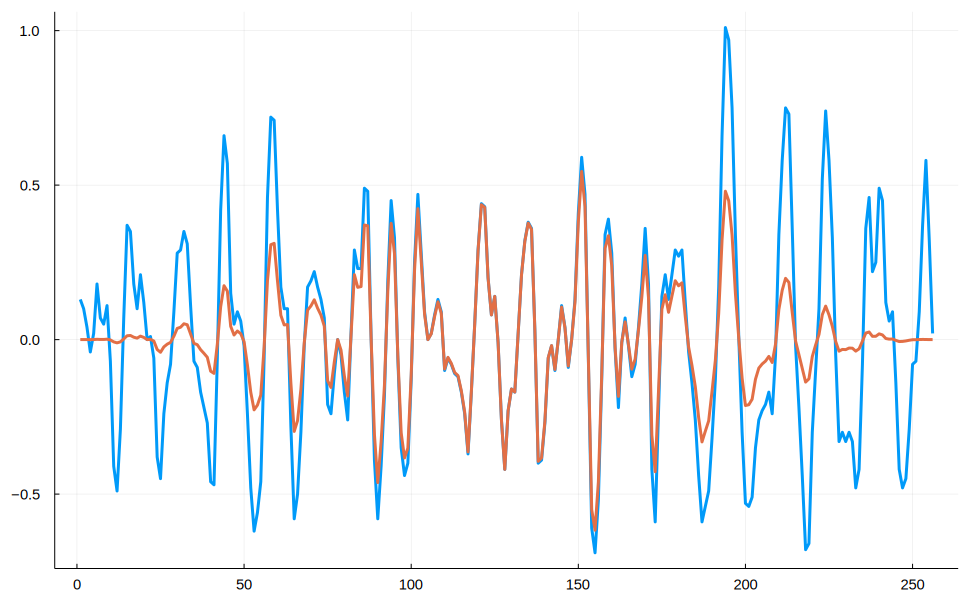

In [64]:
plot(wse_df.Heave[1:256])
plot!(wse_df.Heave[1:256].*w)

In [73]:
atan(23)

1.5273454314033659